# Notebook 03 — YOLOv11 + SimAM Attention 

**Objective:** Train YOLOv11 with a lightweight attention module (SimAM) inserted into the backbone to improve small-object (weed) localization and class separation.

- Architecture: **YOLOv11n** (nano, fast)
- Novelty: **SimAM** attention added after key C2f blocks (P3/P4/P5 stages)
- Dataset: Dataset-agnostic (configurable via CROP_TYPE)
- Protocol: Keep training settings consistent for fair comparison

**To test on different datasets:** Simply change the `CROP_TYPE` variable in the configuration cell below.

### Expected results: 
Feature discriminability for small, low-contrast targets enhancement by improving localization precision.

### Setup & Imports
Using augmented dataset

In [3]:
import os
from pathlib import Path
from ultralytics import YOLO
import pandas as pd
import torch
import torch.nn as nn
from ultralytics.nn.modules.block import C2f, C3k2
import types
from PIL import Image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

dataset = "augmented"

CROP_TYPE = "Black bean"  
EXP_NAME = ORIGINAL_PROJECT_NAME = f"{CROP_TYPE}_simam"

DATASET_ROOT = Path("Weed-crop RGB dataset")
DATASET_DIR = DATASET_ROOT / f"{CROP_TYPE}_augmented"
DATA_CONFIG = DATASET_DIR / f"{CROP_TYPE.lower()}_{dataset}.yaml"

OUTPUT_DIR = Path("runs") 
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
BASELINE_MODEL_PATH = Path("runs") / f"{CROP_TYPE.lower()}_yolo11n_{dataset}.pt"
BASELINE_EVALUATION_PATH = Path("runs") / f"{CROP_TYPE}_{dataset}"

export_name = f"{CROP_TYPE.lower()}_yolo11n_simam.pt"
export_path = OUTPUT_DIR / export_name

BASE_WEIGHTS = "yolo11n.pt"  
model = YOLO(BASE_WEIGHTS)

MODEL_NAME = "yolo11n.pt"
IMG_SIZE = 640
BATCH_SIZE = 4    
EPOCHS = 100       
PATIENCE = 20      
DEVICE_ID = 0

### Define SimAM Attention Module

In [6]:
class SimAM(nn.Module):
    """
    A lightweight, parameter-free attention module (SimAM).
    Paper: "SimAM: A Simple, Parameter-Free Attention Module for Convolutional Neural Networks"
    We apply it channel-wise using an energy function; suitable for small-object emphasis.
    """
    def __init__(self, e_lambda=1e-4):
        super().__init__()
        self.e_lambda = e_lambda

    def forward(self, x):
        # x: (B, C, H, W)
        b, c, h, w = x.size()
        n = h * w - 1
        # per-channel mean across spatial dims
        x_mean = x.mean(dim=[2, 3], keepdim=True)
        # variance proxy (energy)
        var = ((x - x_mean) ** 2).sum(dim=[2, 3], keepdim=True) / n
        # attention map
        e_inv = (x - x_mean) ** 2 / (4 * (var + self.e_lambda)) + 0.5
        attn = torch.sigmoid(e_inv)
        return x * attn


### Inject SimAM into YOLOv11 Backbone

In [7]:
import types

def inject_simam(model, stages=('P3', 'P4', 'P5')):
    """
    Insert SimAM after selected C2f blocks in the YOLOv11 backbone.
    We identify blocks heuristically by module type names and their stage order.
    """
    backbone = model.model.model  # nn.Sequential of layers

    # Detect C2f layers and their stage levels based on stride progression
    # Heuristic: Keep a counter to map progression roughly to P3/P4/P5 C2f blocks.
    from ultralytics.nn.modules.block import C2f

    c2f_indices = []
    for idx, m in enumerate(backbone):
        if isinstance(m, C2f):
            c2f_indices.append(idx)

    # If we can't find C2f, just print and return
    if not c2f_indices:
        print("No C2f blocks found — skipping SimAM injection.")
        return

    # Typically, YOLO backbones have several C2f blocks at increasing strides:
    # We target the last 3 C2f blocks as proxies for P3, P4, P5 stages.
    target_idxs = c2f_indices[-3:] if len(c2f_indices) >= 3 else c2f_indices

    print(f"Injecting SimAM after C2f layers at indices: {target_idxs}")

    # Replace each targeted C2f with (C2f -> SimAM) via nn.Sequential
    for ti in target_idxs:
        orig = backbone[ti]
        backbone[ti] = nn.Sequential(orig, SimAM())

# Apply injection
inject_simam(model)
print(model.model)

Injecting SimAM after C2f layers at indices: [16, 19, 22]
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running

### Train YOLOv11 with SimAM module

**Note:** Training will only proceed if SimAM injection was successful.

In [8]:

print(f"Starting training with SimAM-enhanced YOLOv11n...")

train_results = model.train(
    data=str(DATA_CONFIG),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,       # keep 512 for 6GB GPU
    batch=BATCH_SIZE,
    #workers=0,       # stable on Windows
    name=EXP_NAME,
    project=OUTPUT_DIR,
    device=0,
    patience=PATIENCE,     # early stopping
    plots=True,
    exist_ok=True
)

Starting training with SimAM-enhanced YOLOv11n...
New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Black bean_augmented/black bean_augmented.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=tra

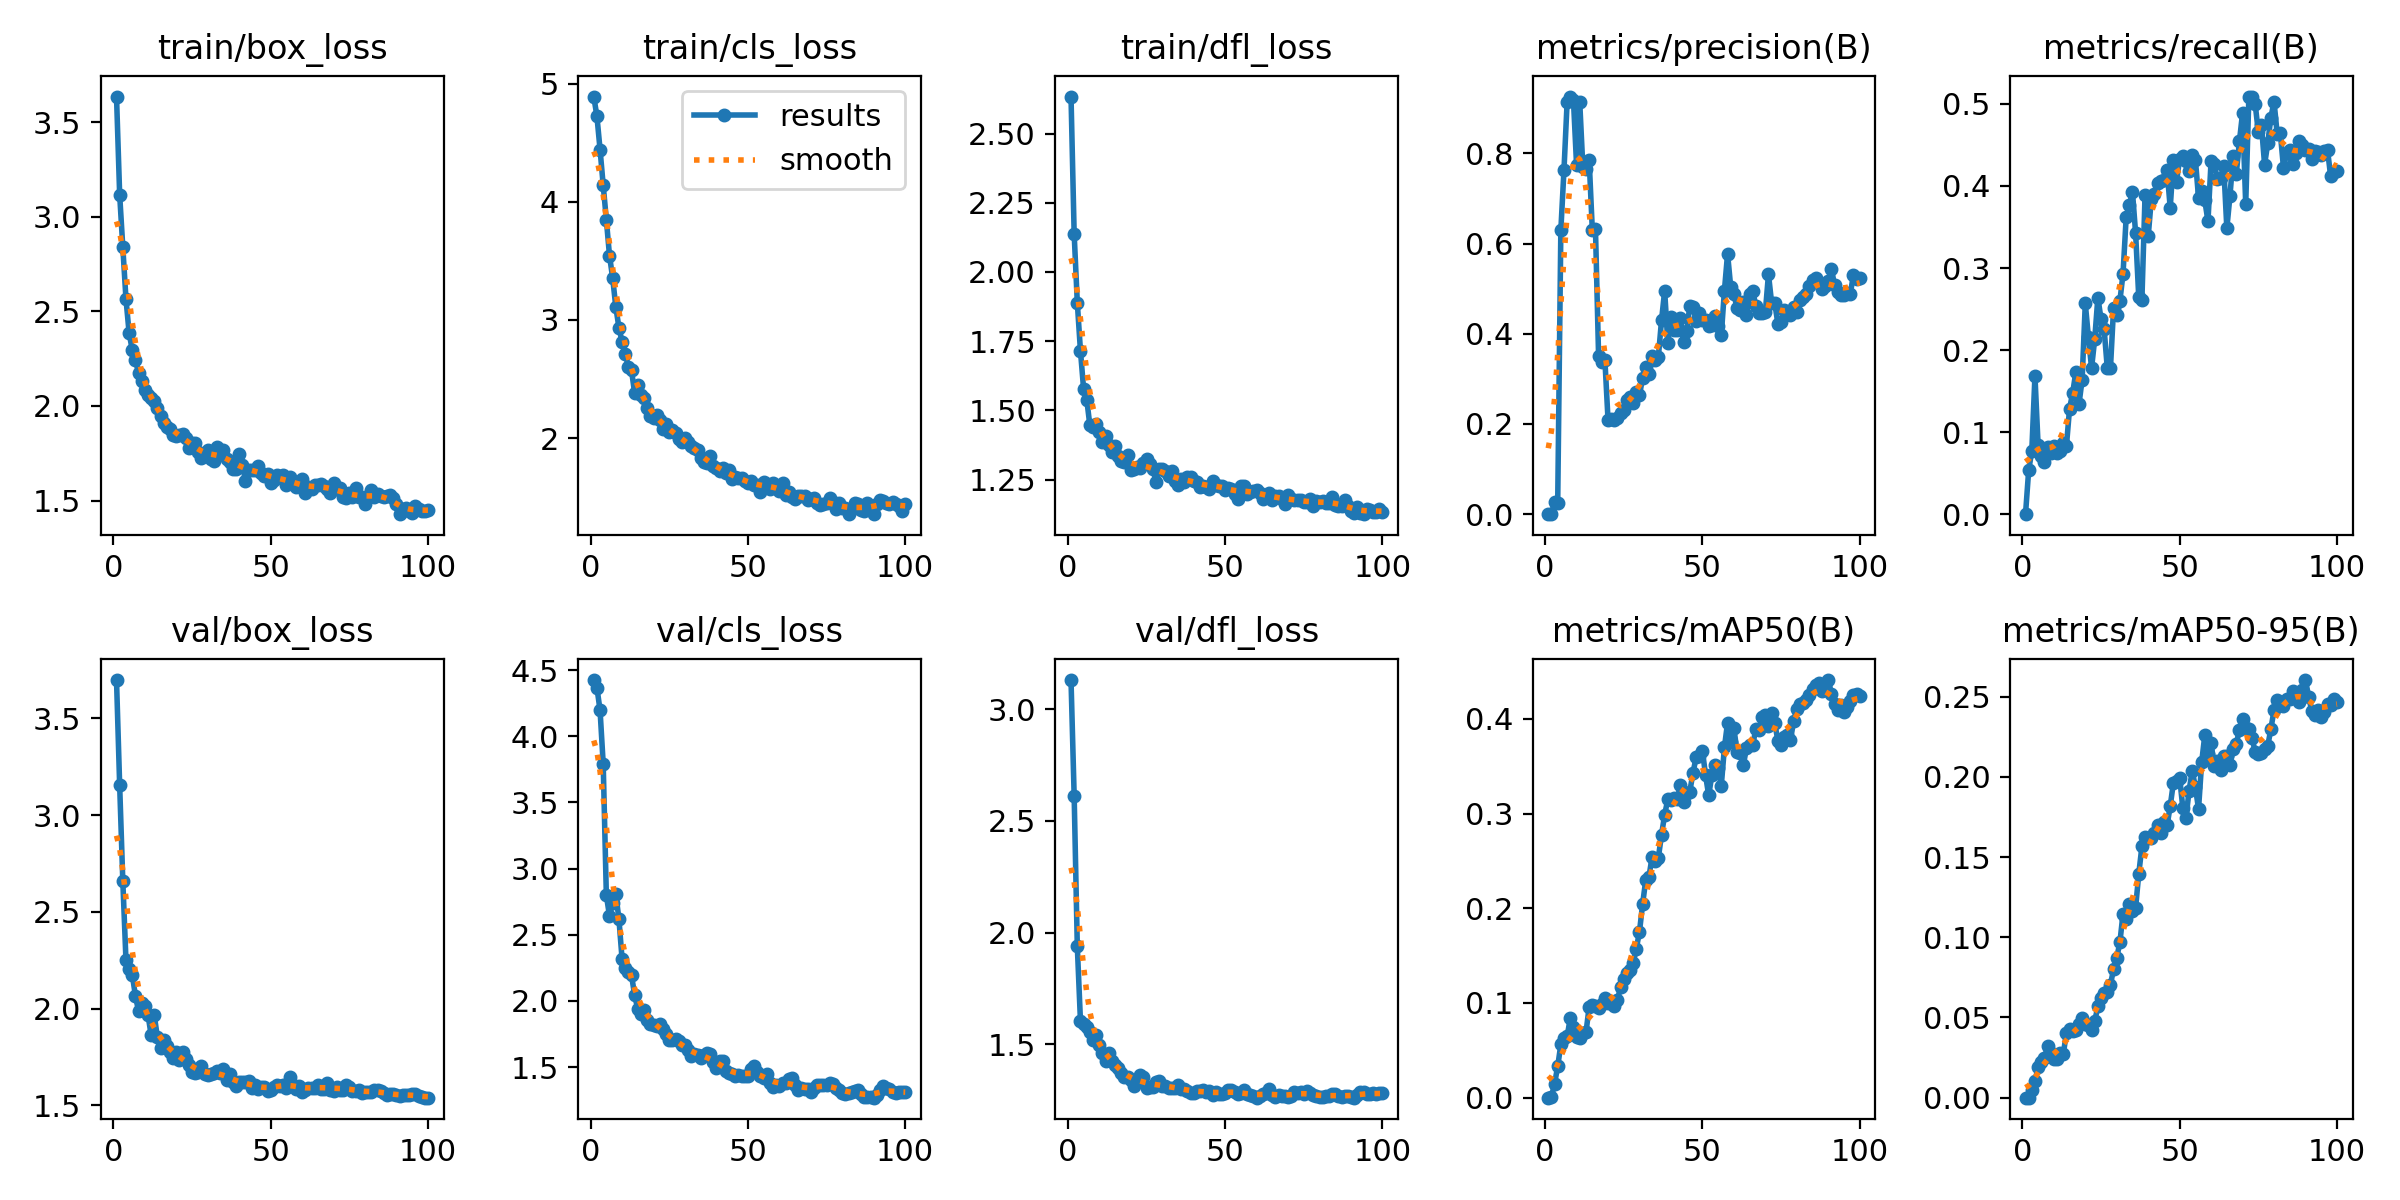

In [10]:
from IPython.display import Image, display
results_path = OUTPUT_DIR / EXP_NAME / "results.png"
display(Image(filename=str(results_path)))

In [11]:
BEST_WEIGHTS_PATH = OUTPUT_DIR / EXP_NAME / 'weights' / 'best.pt'

model_simam = YOLO(str(BEST_WEIGHTS_PATH))

model_simam.save(export_path)

print(f"Model saved to: {export_path}")

Model saved to: runs/black bean_yolo11n_simam.pt


### Evaluate SiamAM model and baseline model


In [9]:
model_simam = YOLO(export_path)

metrics_simam = model_simam.val(
    data=DATA_CONFIG, 
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE_ID,
    split='test', 
    plots=True,
    project=str(OUTPUT_DIR/EXP_NAME),
    name = "evaluation",
    exist_ok=False
)

Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6540.3±1094.0 MB/s, size: 5671.8 KB)
val: Scanning /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Black bean_augmented/test.cache... 39 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 39/39 166.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 5.9it/s 1.7s.3ss
                   all         39        606      0.629      0.349      0.362      0.215
            Black bean         38        446      0.617      0.858      0.808      0.431
                  Flax          1          3          1          0          0          0
             Horseweed          7         12      0.391      0.322      0.319      0.102
                Kochia       

In [14]:
baseline_model = YOLO(BASELINE_MODEL_PATH)

baseline_metrics = baseline_model.val(
    data=str(DATA_CONFIG),
    split='test',
    imgsz=IMG_SIZE,
    verbose=True,
    project=str(BASELINE_EVALUATION_PATH),
    name="evaluation",
    exist_ok=True,
)

Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)


YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2739.9±770.7 MB/s, size: 6640.2 KB)
val: Scanning /home/jula/Repositories/CV/project/crop-weed-detection-1.2/Weed-crop RGB dataset/Black bean_augmented/test.cache... 39 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 39/39 129.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.6it/s 5.3s3.1ss
                   all         39        606      0.615      0.473      0.487      0.293
            Black bean         38        446       0.74      0.845      0.837      0.478
                  Flax          1          3          1          0          0          0
             Horseweed          7         12      0.527      0.835      0.755      0.344
                Kochia         15         28      0.477      0.571      0.554      0.335
                Lentil          1          1     

### Compare metrics

In [15]:
def extract_class_metrics(metrics_obj, label):

    evaluated_iids = metrics_obj.box.ap_class_index.tolist()
    
    ap50_arr = metrics_obj.box.ap50.flatten().tolist()
    ap_arr = metrics_obj.box.ap.flatten().tolist()

    full_class_names = metrics_obj.names
    
    nc_evaluated = len(ap50_arr) 
    
    data_list = []
    
    for i in range(nc_evaluated): 
        
        class_id = evaluated_iids[i]
        class_name = full_class_names[class_id]
        
        data_list.append({
            'Class': class_name, 
            f'mAP@0.5 ({label})': ap50_arr[i],
            f'mAP@0.5:0.95 ({label})': ap_arr[i]
        })

    df = pd.DataFrame(data_list)
    
    df = df[(df[f'mAP@0.5 ({label})'] > 0) | (df[f'mAP@0.5:0.95 ({label})'] > 0)]
    df.set_index('Class', inplace=True)
    return df

In [16]:
def extract_general_metrics(metrics_obj, label):
    
    mp = metrics_obj.box.mp
    mr = metrics_obj.box.mr
    
    total_time_ms = metrics_obj.speed['preprocess'] + metrics_obj.speed['inference'] + metrics_obj.speed['postprocess']
    fps = 1000 / total_time_ms 
    
    precision = mp.mean() if hasattr(mp, 'mean') else mp
    recall = mr.mean() if hasattr(mr, 'mean') else mr

    #ap_small = metrics_obj.box.ap[7] if len(metrics_obj.box.ap) > 7 else 0 

    
    data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)', 
                   #'AP_Small (APs)', 
                   'Inference FPS'],
        label: [
            metrics_obj.box.map50, 
            metrics_obj.box.map, 
            precision, 
            recall,
            #ap_small, 
            fps
        ]
    }
    df = pd.DataFrame(data).set_index('Metric')
    return df

In [17]:

df_simam_general = extract_general_metrics(metrics_simam, 'SimAM')
df_baseline_general = extract_general_metrics(baseline_metrics, 'Baseline')

df_general_comparison = df_simam_general.join(df_baseline_general, how='outer')
df_general_comparison['Difference'] = df_general_comparison['Baseline'] - df_general_comparison['SimAM']

print("\n--- Model Comparison: Overall Metrics  ---")
display(df_general_comparison.round(4))

df_augmented_class = extract_class_metrics(metrics_simam, 'SimAM')
df_baseline_class = extract_class_metrics(baseline_metrics, 'Baseline')

df_class_comparison = df_augmented_class.join(df_baseline_class, how='outer').fillna(0)
df_class_comparison['Diff mAP@0.5'] = df_class_comparison['mAP@0.5 (SimAM)'] - df_class_comparison['mAP@0.5 (Baseline)'] 
df_class_comparison['Diff mAP@0.5:0.95'] = df_class_comparison['mAP@0.5:0.95 (SimAM)'] - df_class_comparison['mAP@0.5:0.95 (Baseline)']

print("\n--- Model Comparison: Class-Wise Details ---")
display(df_class_comparison.round(4))


--- Model Comparison: Overall Metrics  ---


SimAM  Baseline  Difference
Metric                                      
Inference FPS  90.2348   23.8415    -66.3932
Precision (P)   0.6291    0.6152     -0.0139
Recall (R)      0.3485    0.4726      0.1241
mAP@0.5         0.3622    0.4869      0.1247
mAP@0.5:0.95    0.2150    0.2931      0.0781


--- Model Comparison: Class-Wise Details ---


mAP@0.5 (SimAM)  mAP@0.5:0.95 (SimAM)  mAP@0.5 (Baseline)  \
Class                                                                        
Black bean                0.8084                0.4309              0.8375   
Horseweed                 0.3186                0.1022              0.7546   
Kochia                    0.4473                0.2881              0.5539   
Ragweed                   0.4302                0.2546              0.5397   
Redroot Pigweed           0.6987                0.4931              0.8389   
Soybean                   0.2359                0.1578              0.2764   
Waterhemp                 0.3207                0.2083              0.5809   

                 mAP@0.5:0.95 (Baseline)  Diff mAP@0.5  Diff mAP@0.5:0.95  
Class                                                                      
Black bean                        0.4781       -0.0291            -0.0472  
Horseweed                         0.3436       -0.4360            -0.2414  
Kochia                            0.3354       -0.1066            -0.0473  
Ragweed                           0.3007       -0.1095            -0.0461  
Redroot Pigweed                   0.6132       -0.1402            -0.1201  
Soybean                           0.2002       -0.0404            -0.0425  
Waterhemp                         0.3664       -0.2602            -0.1582

We can clearly see, that adding SimAm module made the inference time shorter.

<Figure size 1200x700 with 1 Axes>

Displaying chart: Per-Class mAP@0.5 Comparison (SimAm vs Baseline)


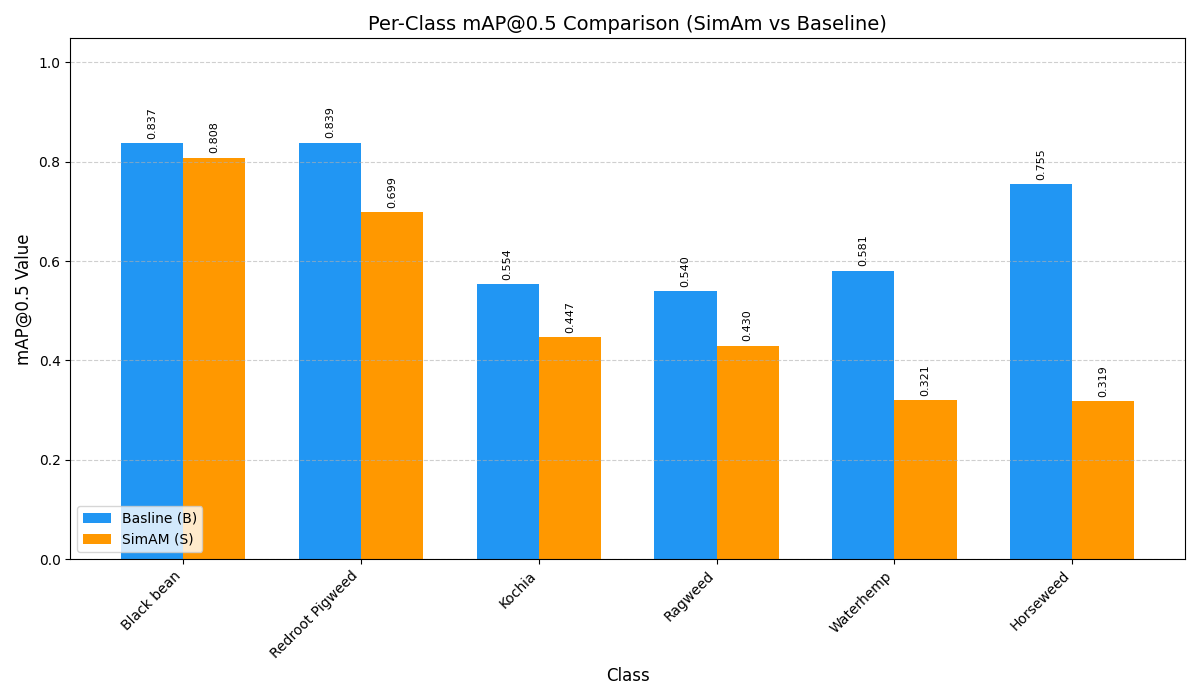

<Figure size 1200x700 with 1 Axes>

Displaying chart: Per-Class mAP@0.5:0.95 Comparison (SimAm vs Baseline)


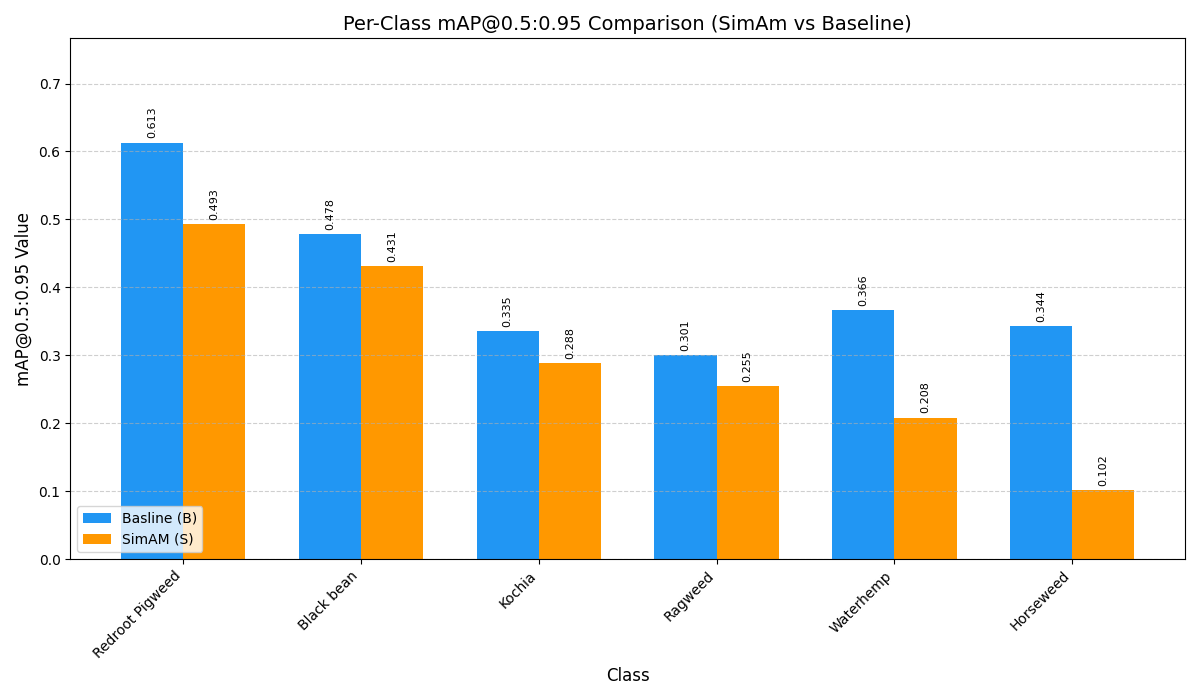

In [18]:
from IPython.display import Image, display
def create_grouped_ap_chart(df, metric_base_name, title):

    simam_col = f'{metric_base_name} (SimAM)'
    baseline_col = f'{metric_base_name} (Baseline)'
    
    if not all(col in df.columns for col in [simam_col, baseline_col]):
        print(f"Error: Columns '{simam_col}' or '{baseline_col}' not found in DataFrame.")
        return

    df_chart = df[[simam_col, baseline_col]].sort_values(by=simam_col, ascending=False)
    
    bar_width = 0.35
    classes = df_chart.index
    r = np.arange(len(classes))
    
    fig, ax = plt.subplots(figsize=(12, 7))

    bars1 = ax.bar(r - bar_width/2, df_chart[baseline_col], width=bar_width, 
                   label='Basline (B)', color='#2196F3', edgecolor='none')
    bars2 = ax.bar(r + bar_width/2, df_chart[simam_col], width=bar_width, 
                   label='SimAM (S)', color='#FF9800', edgecolor='none')
    

    ax.set_ylabel(f'{metric_base_name} Value', fontsize=12)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(r)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend(loc='lower left')
    ax.set_ylim(0, df_chart.max().max() * 1.25)

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8, rotation=90)

    add_labels(bars1)
    add_labels(bars2)

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    filename = f'{metric_base_name.lower().replace("@", "_")}_simam_comparison.png'
    plt.savefig(filename)
    plt.show() 
    
    try:
        from IPython.display import Image, display
        print(f"Displaying chart: {title}")
        display(Image(filename=filename))
    except ImportError:
        print("IPython.display not available. Chart saved but not displayed.")

TARGET_CLASSES = [
    'Black bean', 'Horseweed', 'Kochia', 
    'Ragweed', 'Redroot Pigweed', 'Waterhemp'
]

df_plot_filtered = df_class_comparison.loc[df_class_comparison.index.intersection(TARGET_CLASSES)]

create_grouped_ap_chart(
    df_plot_filtered, 
    metric_base_name='mAP@0.5', 
    title='Per-Class mAP@0.5 Comparison (SimAm vs Baseline)'
)

create_grouped_ap_chart(
    df_plot_filtered, 
    metric_base_name='mAP@0.5:0.95', 
    title='Per-Class mAP@0.5:0.95 Comparison (SimAm vs Baseline)'
)

The above tables show, that for all classes, even the crop class both metrics decreased significantly. This indicates that both detection and localization deteriorated., especially for Horseweed class.

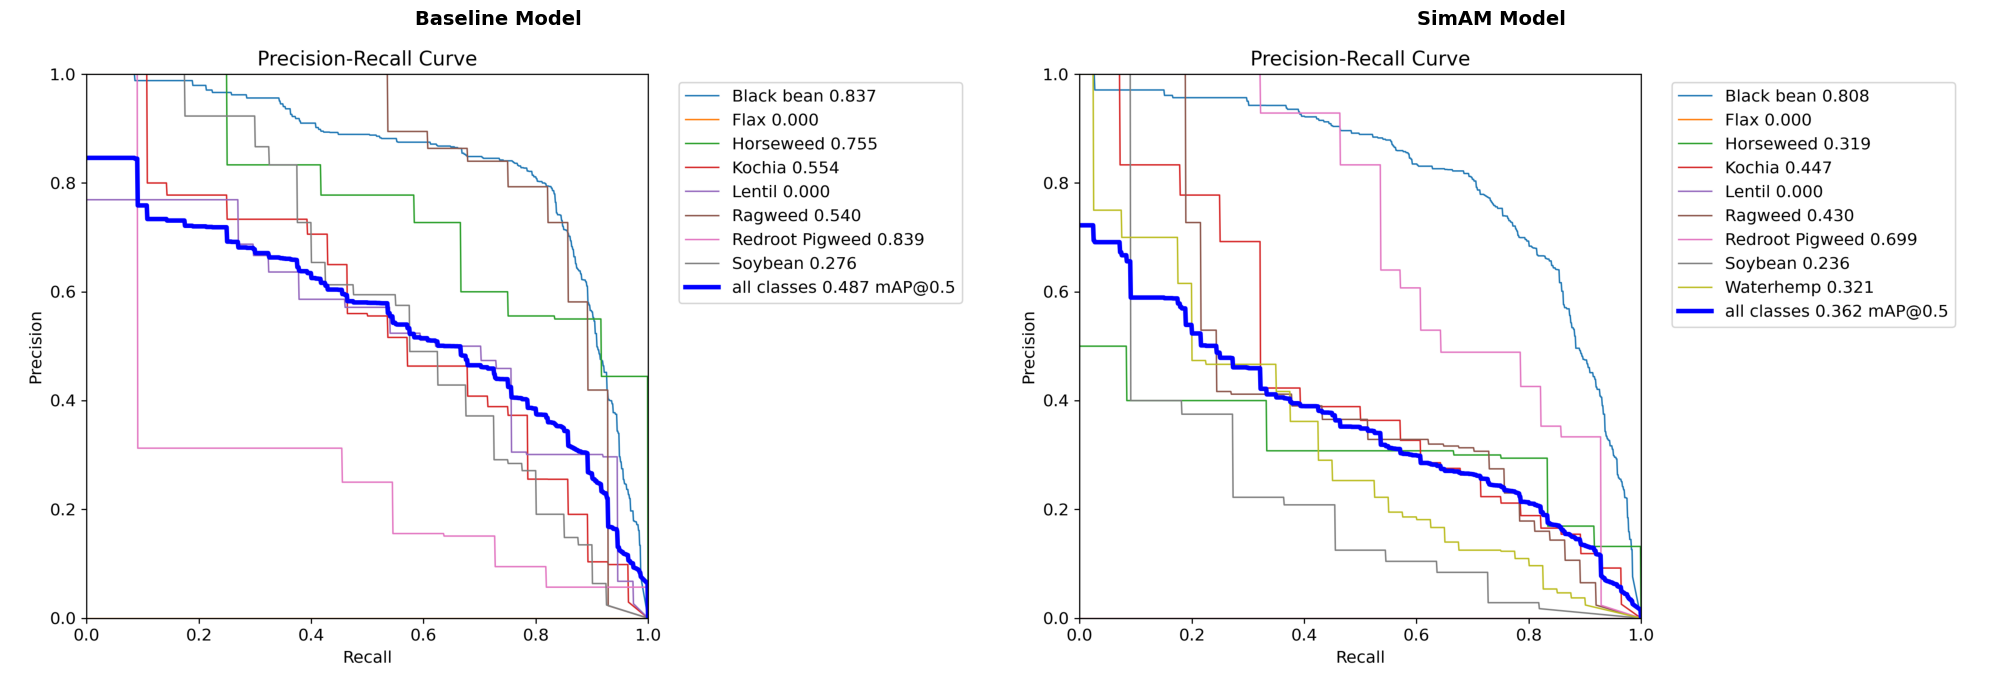

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

def find_pr_plot(folder_path):
    for name in ['BoxPR_curve.png']:
        path = folder_path / name
        if path.exists():
            return path
    return None

DIR_BASELINE = BASELINE_EVALUATION_PATH / "evaluation"
DIR_SIMAM = OUTPUT_DIR / EXP_NAME/ "evaluation"

PATH_BASELINE = find_pr_plot(DIR_BASELINE)
PATH_SIMAM = find_pr_plot(DIR_SIMAM)


TITLE_BASELINE = "Baseline Model"
TITLE_SIMAM = "SimAM Model"

%matplotlib inline

try:
    fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 

    if PATH_BASELINE:
        img_orig = Image.open(PATH_BASELINE)
        axes[0].imshow(img_orig)
        axes[0].set_title(f'{TITLE_BASELINE}', fontsize=14, fontweight='bold')
        axes[0].axis('off')
    else:
        axes[0].text(0.5, 0.5, "No PR", 
                     ha='center', va='center', fontsize=14)
        axes[0].set_title(f'{TITLE_BASELINE} - MISSING', fontsize=14)
        axes[0].axis('off')

    if PATH_SIMAM:
        img_simam = Image.open(PATH_SIMAM)
        axes[1].imshow(img_simam)
        axes[1].set_title(f'{TITLE_SIMAM}', fontsize=14, fontweight='bold')
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, "No PR", 
                     ha='center', va='center', fontsize=14)
        axes[1].set_title(f'{TITLE_SIMAM} - MISSING', fontsize=14, color='red')
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

Precision-recall curves show visible degradation. The curves are starting to resemble the letter 'L', which is the opossite to what we want to achieve. However SimAM module brings back Waterhemp class on the plot and also increases precision and recall of Redroot Pigweed.

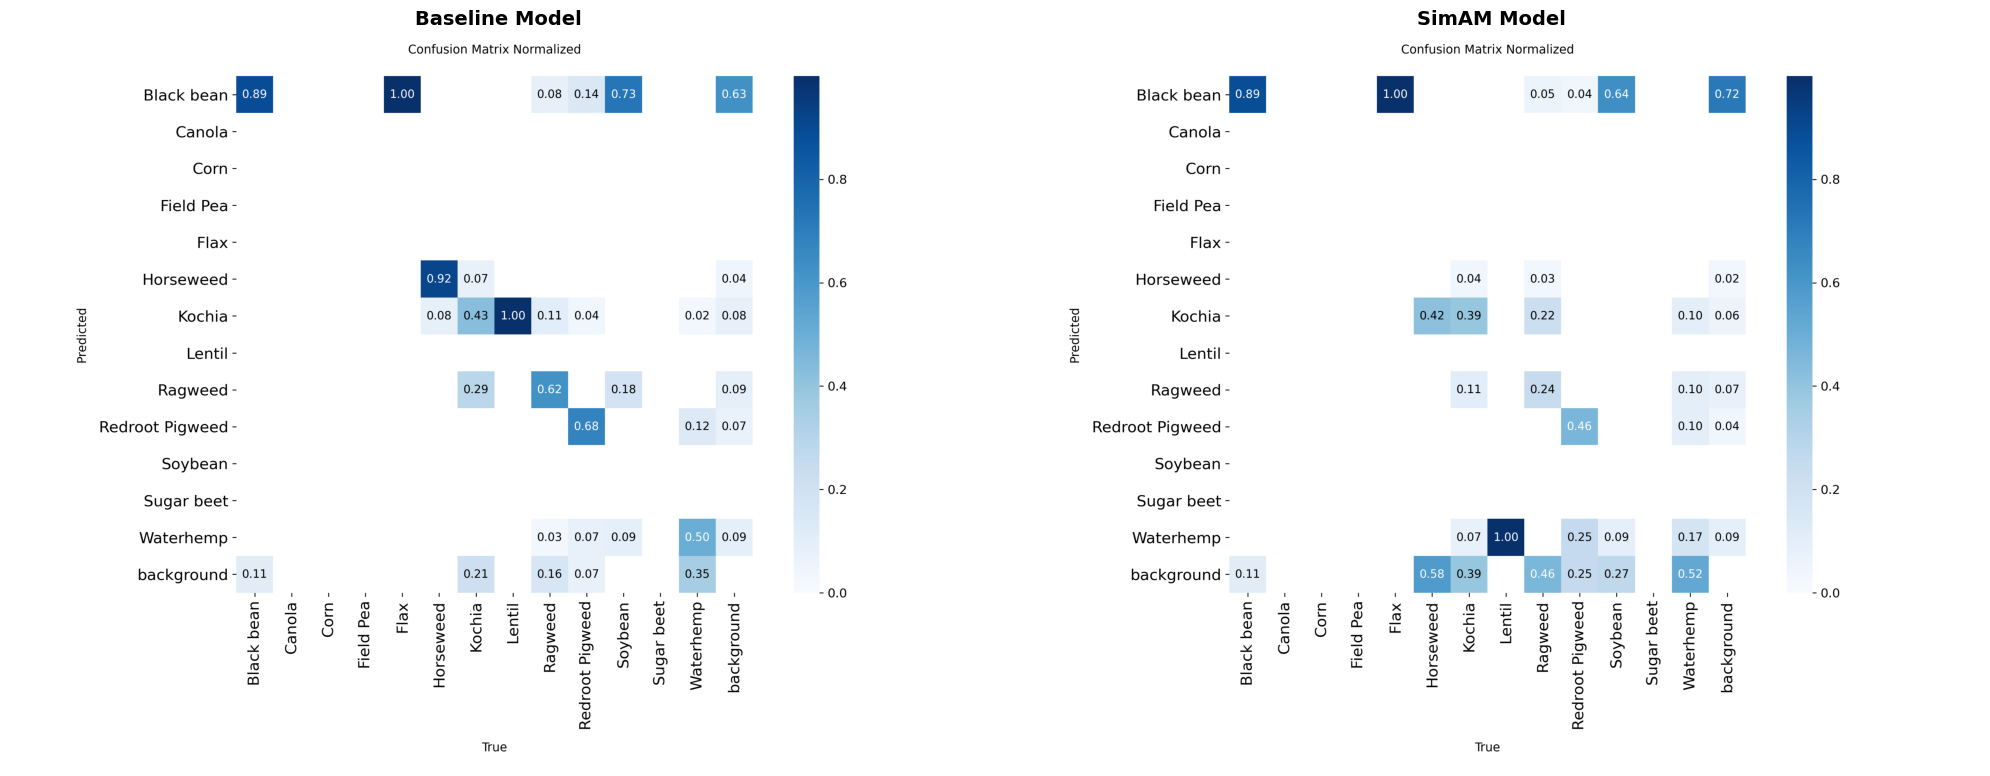

In [20]:
def find_cm_plot(folder_path):
  
    target_files = ['confusion_matrix_normalized.png', 'confusion_matrix.png']
    
    for name in target_files:
        path = folder_path / name
        if path.exists():
            return path
    return None

PATH_CM_BASELINE = find_cm_plot(DIR_BASELINE)
PATH_CM_SIMAM = find_cm_plot(DIR_SIMAM)

try:
    fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 

    # --- PLOT 1: ORIGINAL ---
    if PATH_CM_BASELINE:
        img_cm_orig = Image.open(PATH_CM_BASELINE)
        axes[0].imshow(img_cm_orig)
        axes[0].set_title(f'{TITLE_BASELINE}', fontsize=14, fontweight='bold')
        axes[0].axis('off')
    else:
        axes[0].text(0.5, 0.5, "No confusions matrices\n(Check save_json/plots)", 
                     ha='center', va='center', fontsize=14)
        axes[0].set_title(f'{TITLE_BASELINE} - MISSING', fontsize=14, color='red')
        axes[0].axis('off')

    # --- PLOT 2: SIMAM ---
    if PATH_CM_SIMAM:
        img_cm_simam = Image.open(PATH_CM_SIMAM)
        axes[1].imshow(img_cm_simam)
        axes[1].set_title(f'{TITLE_SIMAM}', fontsize=14, fontweight='bold')
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, "No confusions matrices\n(Check save_json/plots)", 
                     ha='center', va='center', fontsize=14)
        axes[1].set_title(f'{TITLE_SIMAM} - MISSING', fontsize=14, color='red')
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

Confusion matrix shows, that predictions for all weed classes deteriorated. The diagonal became less strong.

### Visualize Sample Predictions

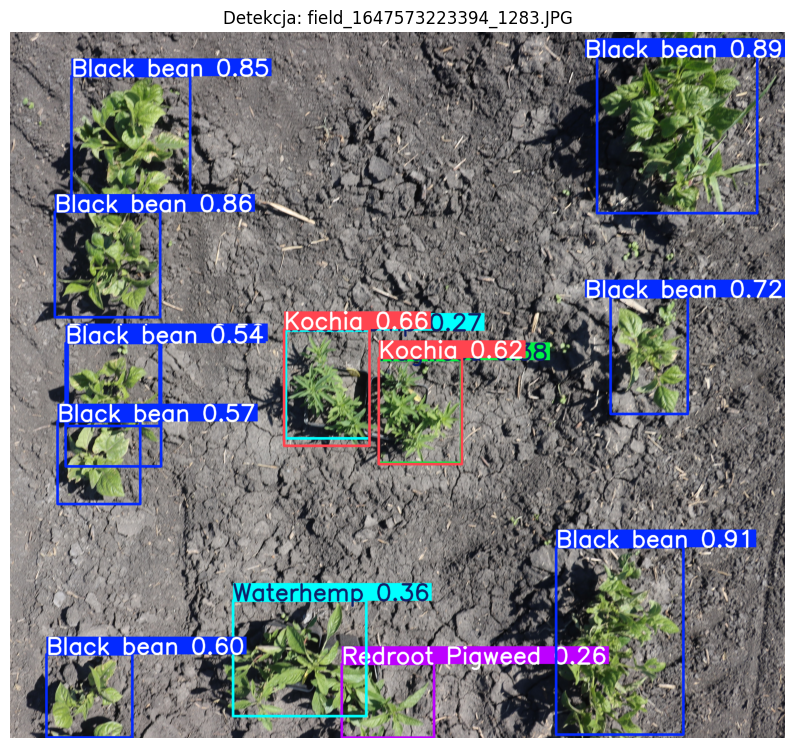

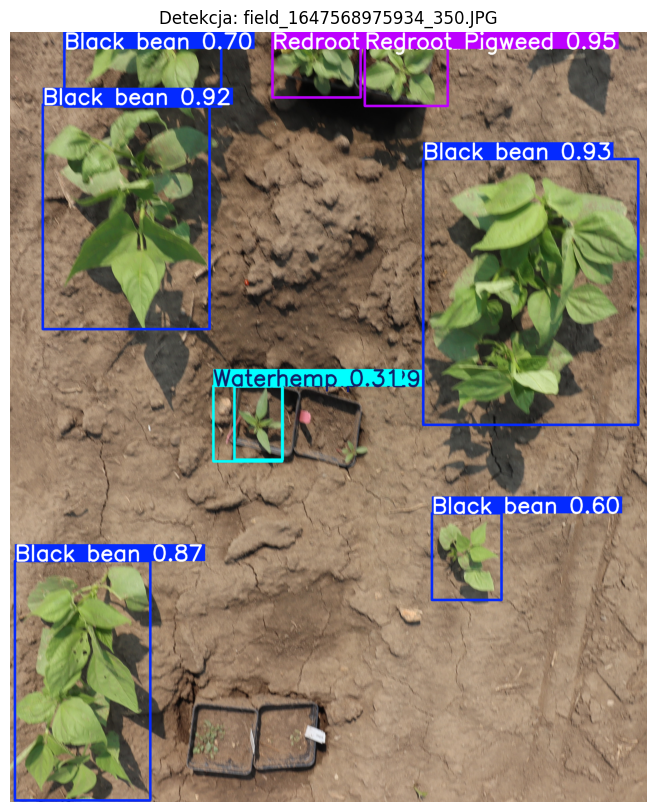

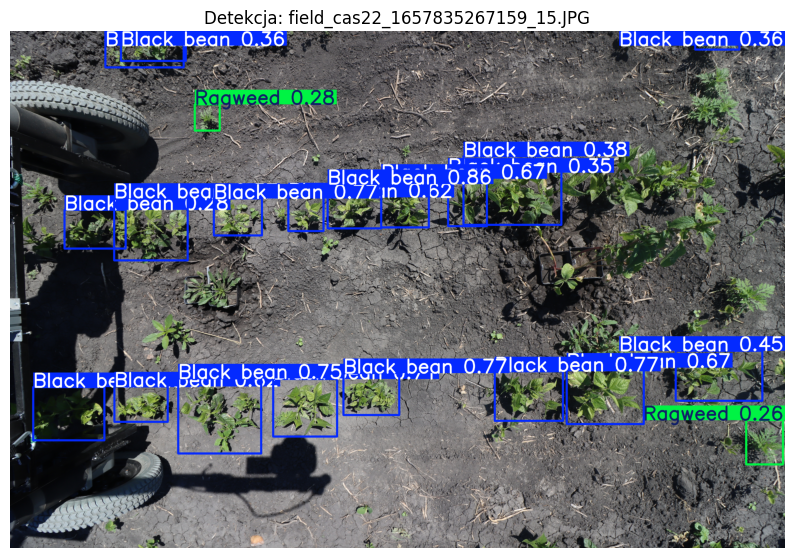

In [20]:
# Use dataset path from configuration
%matplotlib inline
sample_images_dir = DATASET_DIR / "test"
sample_images = list(sample_images_dir.glob("*.jpg"))[:3] + list(sample_images_dir.glob("*.JPG"))[:3]

if not sample_images:
    print(f"No sample images found in {sample_images_dir}")
else:
    for img_path in sample_images:
        results = model_simam.predict(source=str(img_path), save=False, conf=0.25, verbose=False)
        
        for r in results:
            im_bgr = r.plot() 
            
            im_rgb = im_bgr[..., ::-1] 
            
            plt.figure(figsize=(10, 10))
            plt.imshow(im_rgb)
            plt.axis('off')
            plt.title(f"Detekcja: {img_path.name}")
            plt.show()

### Final conclusions

SimAM failed to meet expectations. probably due to its energy-based attention mechanism that inadvertently amplified high-frequency background noise (such as soil texture) instead of the target features. Furthermore, the module's normalization process likely suppressed the already weak feature activations characteristic of extremely small weed instances, effectively filtering them out as background before they could be detected, which led to a collapse in precision rather than the anticipated enhancement.